In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, ebf
import numpy as np, pandas as pd

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")


%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import NullFormatter
import matplotlib
from matplotlib.colors import LogNorm
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)

import seaborn as sns
rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 12,
    'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(font="serif",style="white",rc=rc)

In [2]:
folder = '.../Galaxia_data'
iso_folder = '.../'

## Stars on fields

In [3]:
survey = pd.read_csv(os.path.join(folder, 'Galaxia_sf_survey.csv'))

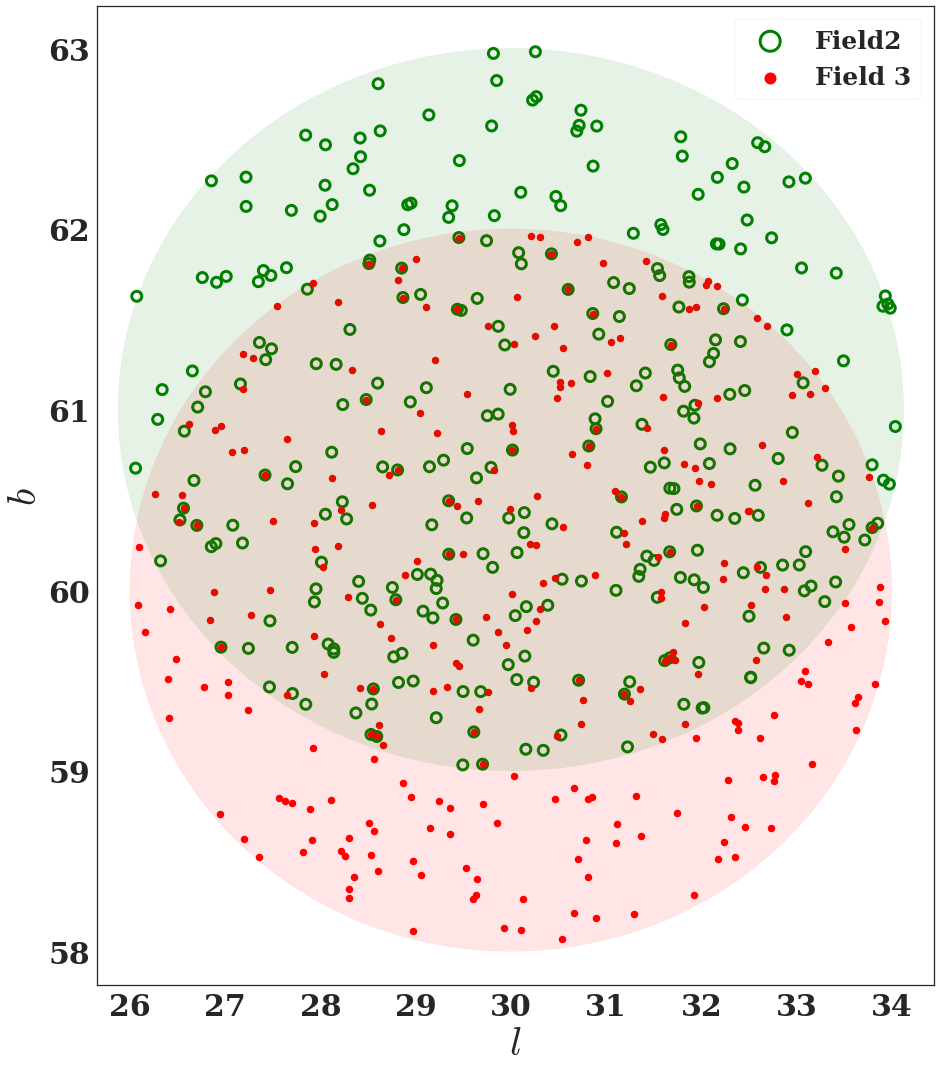

In [4]:
con = np.pi/180
patch1 = matplotlib.patches.Ellipse((30, 60), 4/np.cos(60*con), 4, color='r', fill=True, alpha=0.1)
patch2 = matplotlib.patches.Ellipse((30, 61), 4/np.cos(61*con), 4, color='g', fill=True, alpha=0.1)

fig = plt.figure(figsize=(15, 18))
ax = plt.subplot()

plt.scatter(survey[survey.fieldID == 3.0].glon/con, 
            survey[survey.fieldID == 3.0].glat/con, label='Field2',
            marker='o', c='none', edgecolors='g', s=100, linewidths=3)
plt.scatter(survey[survey.fieldID == 2.0].glon/con, 
            survey[survey.fieldID == 2.0].glat/con, label='Field 3',
            marker='o', c='r', edgecolors='r', s=20, linewidths=3)
#plt.scatter(df23.glon, df23.glat, c='k', s=0.1)

ax.add_artist(patch1)
ax.add_artist(patch2)

plt.rc('mathtext', fontset='cm')
plt.rc('font', family='serif')
plt.xlabel(r'$l$', fontsize=40, style='italic')
plt.ylabel(r'$b$', fontsize=40, style='italic')
plt.tick_params(axis='both', labelsize=30)

plt.legend(fontsize=25, frameon=True, markerscale=2)

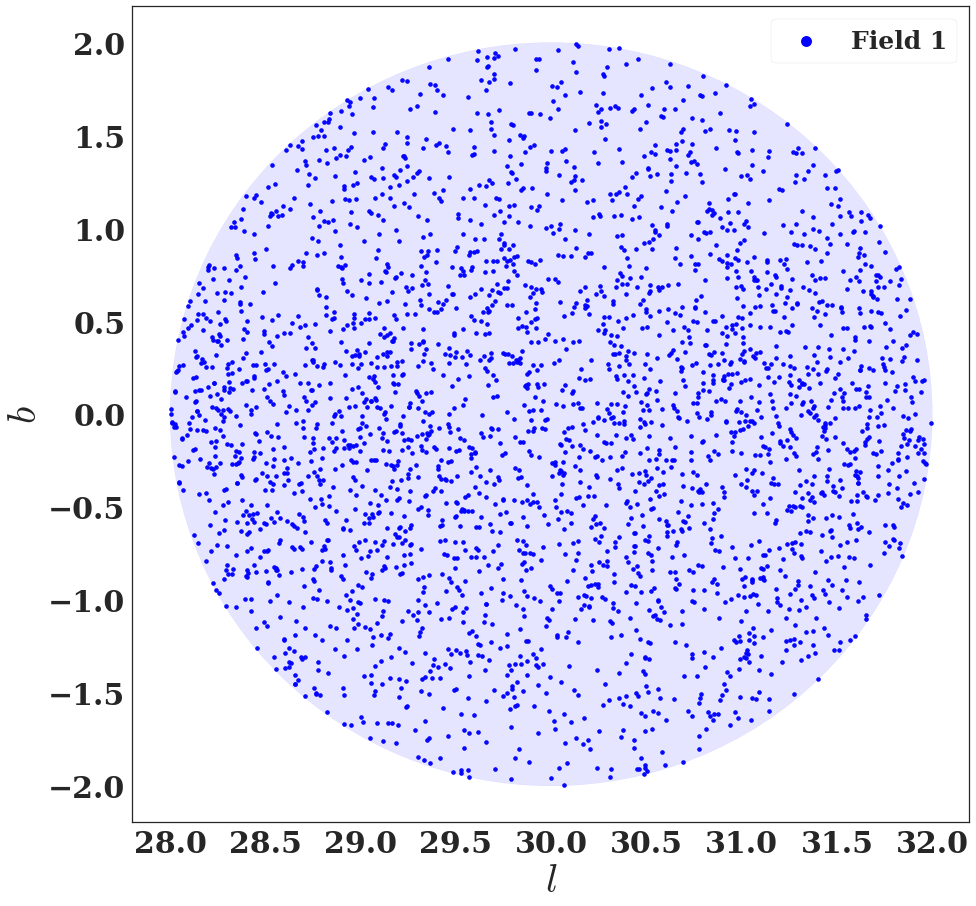

In [5]:
con = np.pi/180
patch1 = matplotlib.patches.Ellipse((30, 0), 4/np.cos(0*con), 4, color='b', fill=True, alpha=0.1)

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot()

plt.scatter(survey[survey.fieldID == 1.0].glon/con, 
            survey[survey.fieldID == 1.0].glat/con, label='Field 1',
            marker='.', c='b', s=10, linewidths=3)

ax.add_artist(patch1)

plt.rc('mathtext', fontset='cm')
plt.rc('font', family='serif')
plt.xlabel(r'$l$', fontsize=40, style='italic')
plt.ylabel(r'$b$', fontsize=40, style='italic')
plt.tick_params(axis='both', labelsize=30)

plt.legend(fontsize=25, frameon=True, markerscale=5)

# Running selection function

In [3]:
from seestar import SelectionGrid, IsochroneScaling

## Generate selection function from scratch

We have prebuilt the 3 component GMM selection functions so only use gen_obsSF() if you wish to rebuild (takes about 20' on 3 cores).

gen_intSF() takes less than a minute so this is fine.

In [5]:
survey = pd.read_csv(folder + '/Galaxia_sf_survey.csv')
survey['Colour'] = survey.Japp-survey.Kapp

pointings = pd.read_csv(folder + '/Galaxia_sf_fieldinfo.csv')
pointings = pointings[['fieldID', 'glon', 'glat', 'halfangle','Magmin', 'Magmax', 'Colmin', 'Colmax']]
pointings.rename({'glon':'phi', 'glat':'theta'})

def get_spectro(field):
    
    field_data = survey[survey.fieldID==field]
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    return field_data

def get_photo(field):
    
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    return field_data

In [7]:
SF = SelectionGrid.SFGenerator(get_spectro, get_photo, pointings, ncores=3,
                              spectro_model=('GMM', 3), photo_model=('GMM', 3))

The spectro model description is:('GMM', 3)
The photo model description is:('GMM', 3)


## Generate new selection functions

In [6]:
%%time
# Load in the isochrone interpolant
IsoCalculator = IsochroneScaling.IntrinsicToObservable()
IsoCalculator.LoadColMag(iso_folder+'/isochrones/isochrone_interpolantinstances.pickle')

CPU times: user 6.14 s, sys: 1.44 s, total: 7.58 s
Wall time: 12.2 s


In [ ]:
%%time
SF.gen_obsSF(folder+'/Galaxia_obsSF.pickle')

Creating colour-magnitude field interpolants...
multiprocessing - observable SF calculation - running on 3 cores...
col-mag calculation finished for field: 1.0, 1/3, Time: 15m, Left: 30m...done
.


In [14]:
%%time
SF.gen_intSF(folder+'/Galaxia_intSF.pickle', IsoCalculator)

Creating distance-age-metallicity interpolants...
...done.

Save as /media/andy/37E3-0F91/Research/SF/SFdata/Galaxia_redesign/Galaxia_intSF.pickle? (y/n)y

Pickling intrinsic SF...


## Load in premade selection function

In [8]:
%%time
# Load observable selection function
#SF.load_obsSF(folder+'/Galaxia_sf_obsSFemceee.pickle')
SF.load_obsSF(folder+'/Galaxia_obsSF.pickle')

Unpickling colour-magnitude interpolant dictionaries...
...done.

CPU times: user 36 ms, sys: 64 ms, total: 100 ms
Wall time: 367 ms


In [9]:
# Load intrinsic selection function
SF.load_intSF(folder+'/Galaxia_intSF.pickle')

Unpickling intrinsic selection function...
...done.



## MCMC around local optima

Again, MCMC runs have been done previously so if you used SF.load_obsSF(), they will already exist.
If not, the emcee run for 2000 iterations takes ~2h

In [10]:
from seestar import SFInstanceClasses
import pickle
from copy import deepcopy

In [14]:
%%time
for field in list(SF.pointings.fieldID):
    inst = SF.obsSF[field].SF_model
    inst.runningL=True
    inst.optimizeParams(method='emceeBall', init='reset')

init,  reset
initial parameters [[-4.17838255  0.60042245  4.00045082  5.57702447  0.0159517   0.61505256]
 [ 0.15729628 -0.91743333  0.5005584   2.41079562  1.35527681  0.05615077]
 [ 0.49339597  0.76811856  0.1773772   4.41562592  2.47808452  0.06247564]]
itern: 1, logL: 15222.70, sum log(f(xi)): 18316.26, integral: 3093.56                
Initparam likelihood: 15222.70
itern: 0, logL: 15222.70, sum log(f(xi)): 18316.26, integral: 3093.56                \nInit  lnl:  -15222.700901748309 \n
emcee with 2000 iterations...
itern: 46384, logL: 15232.18, sum log(f(xi)): 18300.52, integral: 3068.34                
itern: 46386, logL: 15236.38, sum log(f(xi)): 18359.82, integral: 3123.44                
 emceeBall: lnprob=15236, time=3211
init,  reset
initial parameters [[ -2.68706967  -0.38594158   1.04282587   7.92005862   1.29764421
    5.38147109]
 [  0.38211516  -1.9875036    0.25763134  18.03415267   0.26860365
    1.77964795]
 [  0.38211516  -1.9875036    0.25763136 111.19048091   1.6

In [15]:
inst = deepcopy(SF.obsSF)
obsSF_path = folder+'/Galaxia_obsSFemceee.pickle'
obsSF_dicts = SFInstanceClasses.obsSF_classtodict(inst)

for field in list(SF.pointings.fieldID):
    delattr(obsSF_dicts[field]['SF_model']['output'], 'lnprobfn')
    
with open(obsSF_path, 'wb') as handle:
    pickle.dump(obsSF_dicts, handle, protocol=2)

# Load data files

In [16]:
# Load in spectroscopic data
survey = pd.read_csv(folder + '/Galaxia_sf_survey.csv')
# Calculate colour and magnitude of spectroscopic data
survey['Colour'], survey['Happ'] = IsoCalculator.ColourMapp(survey.ageGyr, survey.mh, survey.mass, survey.s)

# Separate spectroscopic data into field 1 and field 2, 3 overlapping
survey1 = survey[survey.fieldID == 1.0]
survey23 = survey[survey.fieldID.apply(lambda x: x in [2.0,3.0])]

In [17]:
s1 = get_spectro(1.0)

In [18]:
# Load in field 1 photometric data
full1 = pd.read_csv(folder+'/photometric/'+str(1.0)+'.csv')
full1['Colour'] = full1['Japp']-full1['Kapp']
full1.rename(index=str, columns={'feh':'mh', 'smass':'mass','rad':'s'}, inplace=True)
full1['Colour'], full1['Happ'] = IsoCalculator.ColourMapp(full1.ageGyr, full1.mh, full1.mass, full1.s)

In [19]:
# Load in field 2, 3 photometric data

full23 = pd.DataFrame()
fields= [2.0,3.0]
for field in fields:
    full23 = pd.concat((full23, pd.read_csv(folder+'/photometric/'+str(field)+'.csv')))
full23['Colour'] = full23['Japp']-full23['Kapp']
full23.rename(index=str, columns={'feh':'mh', 'smass':'mass','rad':'s'}, inplace=True)
# Recalculate to make colour and apparent magnitude agree
full23['Colour'], full23['Happ'] = IsoCalculator.ColourMapp(full23.ageGyr, full23.mh, full23.mass, full23.s)

In [20]:
survey23 = survey23.drop_duplicates(subset=['glon','glat'], keep='first', inplace=False)
full23 = full23.drop_duplicates(subset=['glon','glat'], keep='first', inplace=False)

# Calculate SF probabilities

In [21]:
# Percentile threshold
s1_prob = 31.73*0.01
# Number of samples
Ns = 25

## Field 1
- For calculating probabilities you can use the union calculation (which takes longer for large datasets and is memory intensive.
- Or if you know that the fields are not overlapping you can calculate direct from the obsSF instances.
- For field 1 we'll demonstrate both.

In [22]:
field=1.0
# Get burnt chain
sampler = SF.obsSF[field].SF_model.output
burnt_chain = sampler.chain[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3, :].copy()
burnt_prob = sampler.lnprobability[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3].copy()
# Take random set of samples within the 68.37 percentile (1sigma)
prob = np.sort(burnt_prob.flatten())
s1_threshold = prob[int(s1_prob*len(prob)):][0]
sample_threshold = burnt_chain[burnt_prob>s1_threshold]
posterior_samples = sample_threshold[(np.random.rand(Ns)*sample_threshold.shape[0]).astype(int)].reshape(-1,3,6)
# Get highest probability parameters
index = np.unravel_index(np.argmax(sampler.lnprobability), sampler.lnprobability.shape)
best = sampler.chain[index].reshape(-1,3,6)[0].copy()

In [23]:
%%time
# Generate observable coord sample from union calculation
instance = SF.obsSF[field].SF_model
params_f = instance.params_f.copy()
# Condition that stars lie within cm boundaries
con_bound = (full1.Happ>SF.obsSF[field].SF_magrange[0])&(full1.Happ<SF.obsSF[field].SF_magrange[1])&\
            (full1.Colour>SF.obsSF[field].SF_colrange[0])&(full1.Colour<SF.obsSF[field].SF_colrange[1])

instance.params_f = instance.unscaleParams(best)
full1['union_f'] = \
    SF(full1, method='observable', coords=['Happ', 'Colour'], angle_coords=['glon', 'glat']).union
full1['union_f'][~con_bound] = 0.
instance.params_f = params_f

Calculating all SF values...
...Assigning: 2160082/2160082        
Calculating: 2160082/2160082        ...done
Calculating union contribution...
...done
CPU times: user 1min 27s, sys: 2.74 s, total: 1min 30s
Wall time: 1min 29s


/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [24]:
%%time
# Generate posterior coord samples straight from obsSF
for i in range(Ns):
    
    rand_pars = posterior_samples[i].copy()
    instance.params_f = instance.unscaleParams(rand_pars)
    
    full1['union_%d'%i] = instance(full1.Happ, full1.Colour)
    
    full1['union_%d'%i][~con_bound] = 0.
    
instance.params_f = params_f

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


CPU times: user 28.1 s, sys: 9.07 s, total: 37.2 s
Wall time: 34.7 s


In [45]:
%%time
# Generate intrinsic coord sample from union calculation
full1['union_int_f'] = \
    SF(full1, method='intrinsic', coords=['ageGyr', 'mh', 's', 'mass'], angle_coords=['glon', 'glat']).union
full1['union_int_f'][~con_bound] = 0.

Calculating all SF values...
...Assigning: 2160082/2160082        
Calculating: 2160082/2160082        ...done
Calculating union contribution...
...done


/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: cannot reindex from a duplicate axis

In [ ]:
# Generate posterior intrinsic coord samples straigh from intSF
for i in range(Ns):
    
    rand_pars = posterior_samples[i].copy()
    instance.params_f = instance.unscaleParams(rand_pars)
    
    full1['union_int_%d'%i] = SF.instanceSF((full1.ageGyr, full1.mh, full1.mass, full1.s), SF.obsSF[field])
    
    full1['union_int_%d'%i][~con_bound] = 0.
    
instance.params_f = params_f

# Field 2 & 3

In [25]:
field = 2.0

shp = SF.obsSF[field].SF_model.output.chain.shape[:2] + (SF.obsSF[2.0].SF_model.nComponents,) + (-1,)
chain = SF.obsSF[field].SF_model.output.chain.reshape(shp)
flatchain = SF.obsSF[field].SF_model.output.flatchain


sampler = SF.obsSF[field].SF_model.output
burnt_chain = sampler.chain[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3, :].copy()
burnt_prob = sampler.lnprobability[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3].copy()

prob = np.sort(burnt_prob.flatten())
s1_threshold = prob[int(s1_prob*len(prob)):][0]
sample_threshold = burnt_chain[burnt_prob>s1_threshold]

posterior2 = sample_threshold[(np.random.rand(Ns)*sample_threshold.shape[0]).astype(int)].reshape(-1, 3, 6)

In [26]:
field = 3.0

shp = SF.obsSF[field].SF_model.output.chain.shape[:2] + (SF.obsSF[2.0].SF_model.nComponents,) + (-1,)
chain = SF.obsSF[field].SF_model.output.chain.reshape(shp)
flatchain = SF.obsSF[field].SF_model.output.flatchain

sampler = SF.obsSF[field].SF_model.output
burnt_chain = sampler.chain[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3, :].copy()
burnt_prob = sampler.lnprobability[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3].copy()

prob = np.sort(burnt_prob.flatten())
s1_threshold = prob[int(s1_prob*len(prob)):][0]
sample_threshold = burnt_chain[burnt_prob>s1_threshold]

posterior3 = sample_threshold[(np.random.rand(Ns)*sample_threshold.shape[0]).astype(int)].reshape(-1, 3, 6)

In [27]:
instance2 = SF.obsSF[2.0].SF_model
instance3 = SF.obsSF[3.0].SF_model
params_f2 = instance2.params_f.copy()
params_f3 = instance3.params_f.copy()

con_bound = (full23.Happ>SF.obsSF[field].SF_magrange[0])&(full23.Happ<SF.obsSF[field].SF_magrange[1])&\
            (full23.Colour>SF.obsSF[field].SF_colrange[0])&(full23.Colour<SF.obsSF[field].SF_colrange[1])

for i in range(Ns):
    
    rand_pars2 = posterior2[i].copy()
    instance2.params_f = instance2.unscaleParams(rand_pars2)
    rand_pars3 = posterior3[i].copy()
    instance3.params_f = instance3.unscaleParams(rand_pars3)
    
    full23['union_%d'%i] = \
        SF(full23, method='observable', coords=['Happ', 'Colour'], angle_coords=['glon', 'glat']).union
    full23['union_%d'%i][~con_bound] = 0.
    
instance2.params_f = params_f2
instance3.params_f = params_f3
full23['union_f'] = \
        SF(full23, method='observable', coords=['Happ', 'Colour'], angle_coords=['glon', 'glat']).union
full23['union_f'][~con_bound] = 0.

Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()



Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 1062

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
instance2 = SF.obsSF[2.0].SF_model
instance3 = SF.obsSF[3.0].SF_model
params_f2 = instance2.params_f.copy()
params_f3 = instance3.params_f.copy()

con_bound = (full23.Happ>SF.obsSF[field].SF_magrange[0])&(full23.Happ<SF.obsSF[field].SF_magrange[1])&\
            (full23.Colour>SF.obsSF[field].SF_colrange[0])&(full23.Colour<SF.obsSF[field].SF_colrange[1])

for i in range(Ns):
    
    rand_pars2 = posterior2[i].copy()
    instance2.params_f = instance2.unscaleParams(rand_pars2)
    rand_pars3 = posterior3[i].copy()
    instance3.params_f = instance3.unscaleParams(rand_pars3)
    
    full23['union_%d'%i] = \
        SF(full23, method='intrinsic', coords=['ageGyr', 'mh', 's', 'mass'], angle_coords=['glon', 'glat']).union
    full23['union_%d'%i][~con_bound] = 0.
    
instance2.params_f = params_f2
instance3.params_f = params_f3
full23['union_f'] = \
        SF(full23, method='intrinsic', coords=['ageGyr', 'mh', 's', 'mass'], angle_coords=['glon', 'glat']).union
full23['union_f'][~con_bound] = 0.

Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 1062

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Plot results

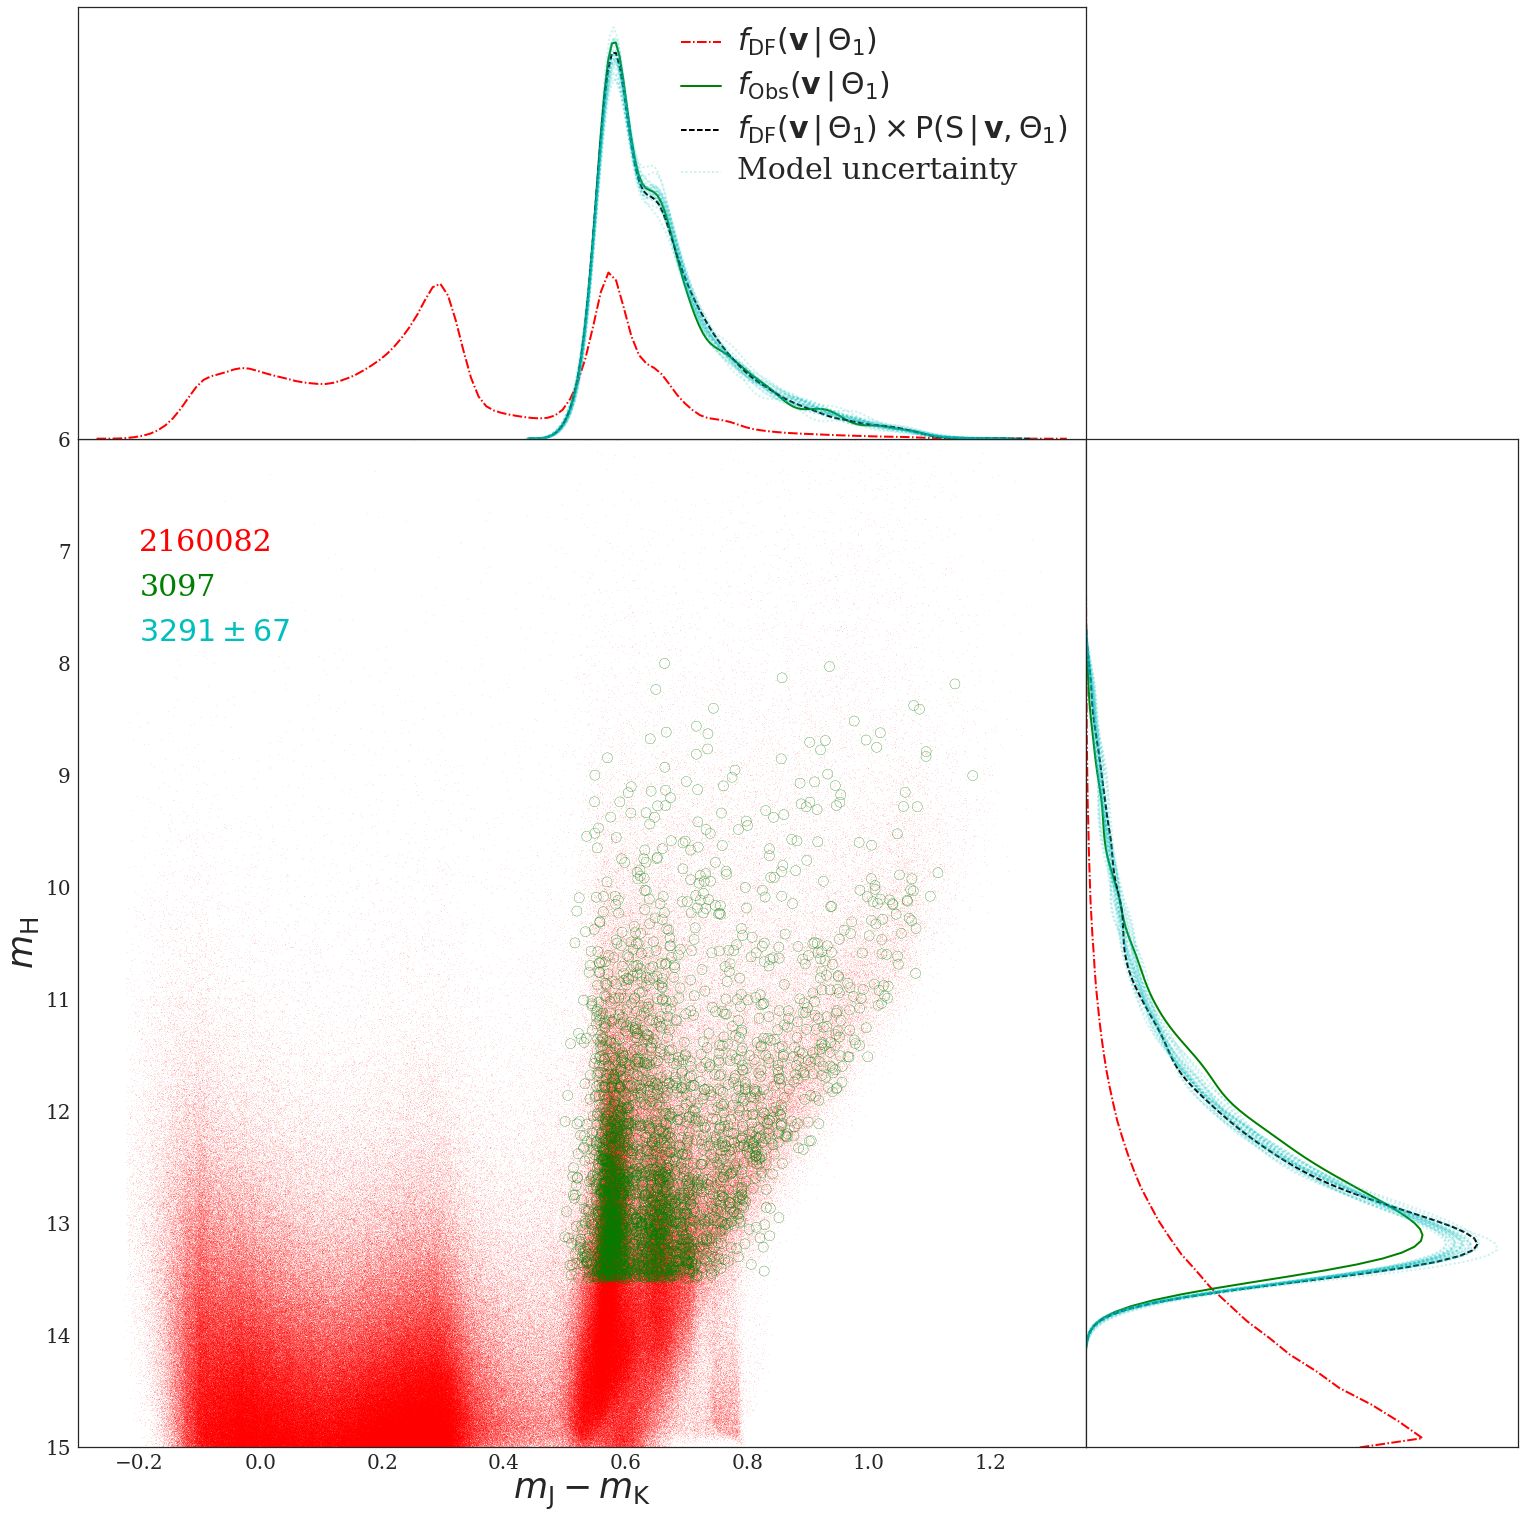

In [30]:
nullfmt = NullFormatter()         # no labels
font = {'family' : 'serif', 'weight' : 'normal',
        'size'   : 80}
legend = {'fontsize': 20}
matplotlib.rc('font', **font)
matplotlib.rc('legend', **legend)
matplotlib.rc('axes', labelsize= 20)

# start with a rectangular Figure
plt.figure(1, figsize=(20, 20))

sml, big = (0.3, 0.7)
ax_c = plt.axes([0, 0, big, big])
ax_t = plt.axes([0, big, big, sml])
ax_s = plt.axes([big, 0., sml, big])

#xlim = (0, 13)
ylim = (15, 6)

# the scatter plot:
ax_c.scatter(full1.Colour, full1.Happ, s=0.01, c='r')
ax_c.scatter(survey1.Colour, survey1.Happ, s=100, marker='o', c='none', edgecolors='g')

#ax_c.set_xlim(xlim)
ax_c.set_ylim(ylim)

label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_1)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_1)$'

plt.sca(ax_t)
sns.kdeplot(full1.Colour, label=label1, alpha=1., c='r', legend=True, linestyle='-.', linewidth=2)
sns.kdeplot(survey1.Colour, label=label2, alpha=1., c='g', legend=True, linestyle='-', linewidth=2)

plt.sca(ax_s)
sns.kdeplot(full1.Happ, alpha=1., c='r', legend=False, vertical=True, linestyle='-.', linewidth=2)
sns.kdeplot(survey1.Happ, alpha=1., c='g', legend=False, vertical=True, linestyle='-', linewidth=2)

df_rand = full1[np.random.rand(len(full1)) < full1['union_f']][['Colour', 'Happ']].copy()
kwargs = {'alpha':1., 'color':'k'}
plt.sca(ax_s)
sns.kdeplot(df_rand.Happ, legend=False, vertical=True, linestyle='--', linewidth=2, zorder=2, **kwargs)
plt.sca(ax_t)
sns.kdeplot(df_rand.Colour, linestyle='--', linewidth=2, label=label3, legend=True, zorder=2, **kwargs)
N=Ns
nrand = np.zeros(Ns)
for i in range(N):
    df_rand = full1[np.random.rand(len(full1)) < full1['union_%d' %i]][['Colour', 'Happ']].copy()

    kwargs = {'alpha':0.2, 'color':'c'}
    if i==0: labelargs = {'label':'Model uncertainty', 'legend':True}
    else: labelargs = {'legend':False}

    plt.sca(ax_s)
    sns.kdeplot(df_rand.Happ, legend=False, vertical=True, linestyle=':', linewidth=2, **kwargs)

    plt.sca(ax_t)
    kwargs.update(labelargs)
    sns.kdeplot(df_rand.Colour, linestyle=':', linewidth=2, **kwargs)
    nrand[i] = len(df_rand)
    
    
ax_t.set_xlim(ax_c.get_xlim())
ax_s.set_ylim(ax_c.get_ylim())

plt.sca(ax_c)
textfont = {'fontsize':30}
plt.text(-0.2, 7., str(len(full1)), color='r', fontdict=textfont)
plt.text(-0.2, 7.4, str(len(survey1)), color='g', fontdict=textfont)
plt.text(-0.2, 7.8, r'$%d \pm %d$' % (np.mean(nrand), np.std(nrand)), color='c', fontdict=textfont)

ax_c.tick_params('x', labelsize=20)
ax_c.tick_params('y', labelsize=20)
ax_s.tick_params('both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')
ax_t.tick_params('both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')

ax_c.set_xlabel(r'$m_\mathrm{J} - m_\mathrm{K}$', fontsize=35)
ax_c.set_ylabel(r'$m_\mathrm{H}$', fontsize=35)

plt.setp(ax_t.get_legend().get_texts(), fontsize='30') 

plt.show()

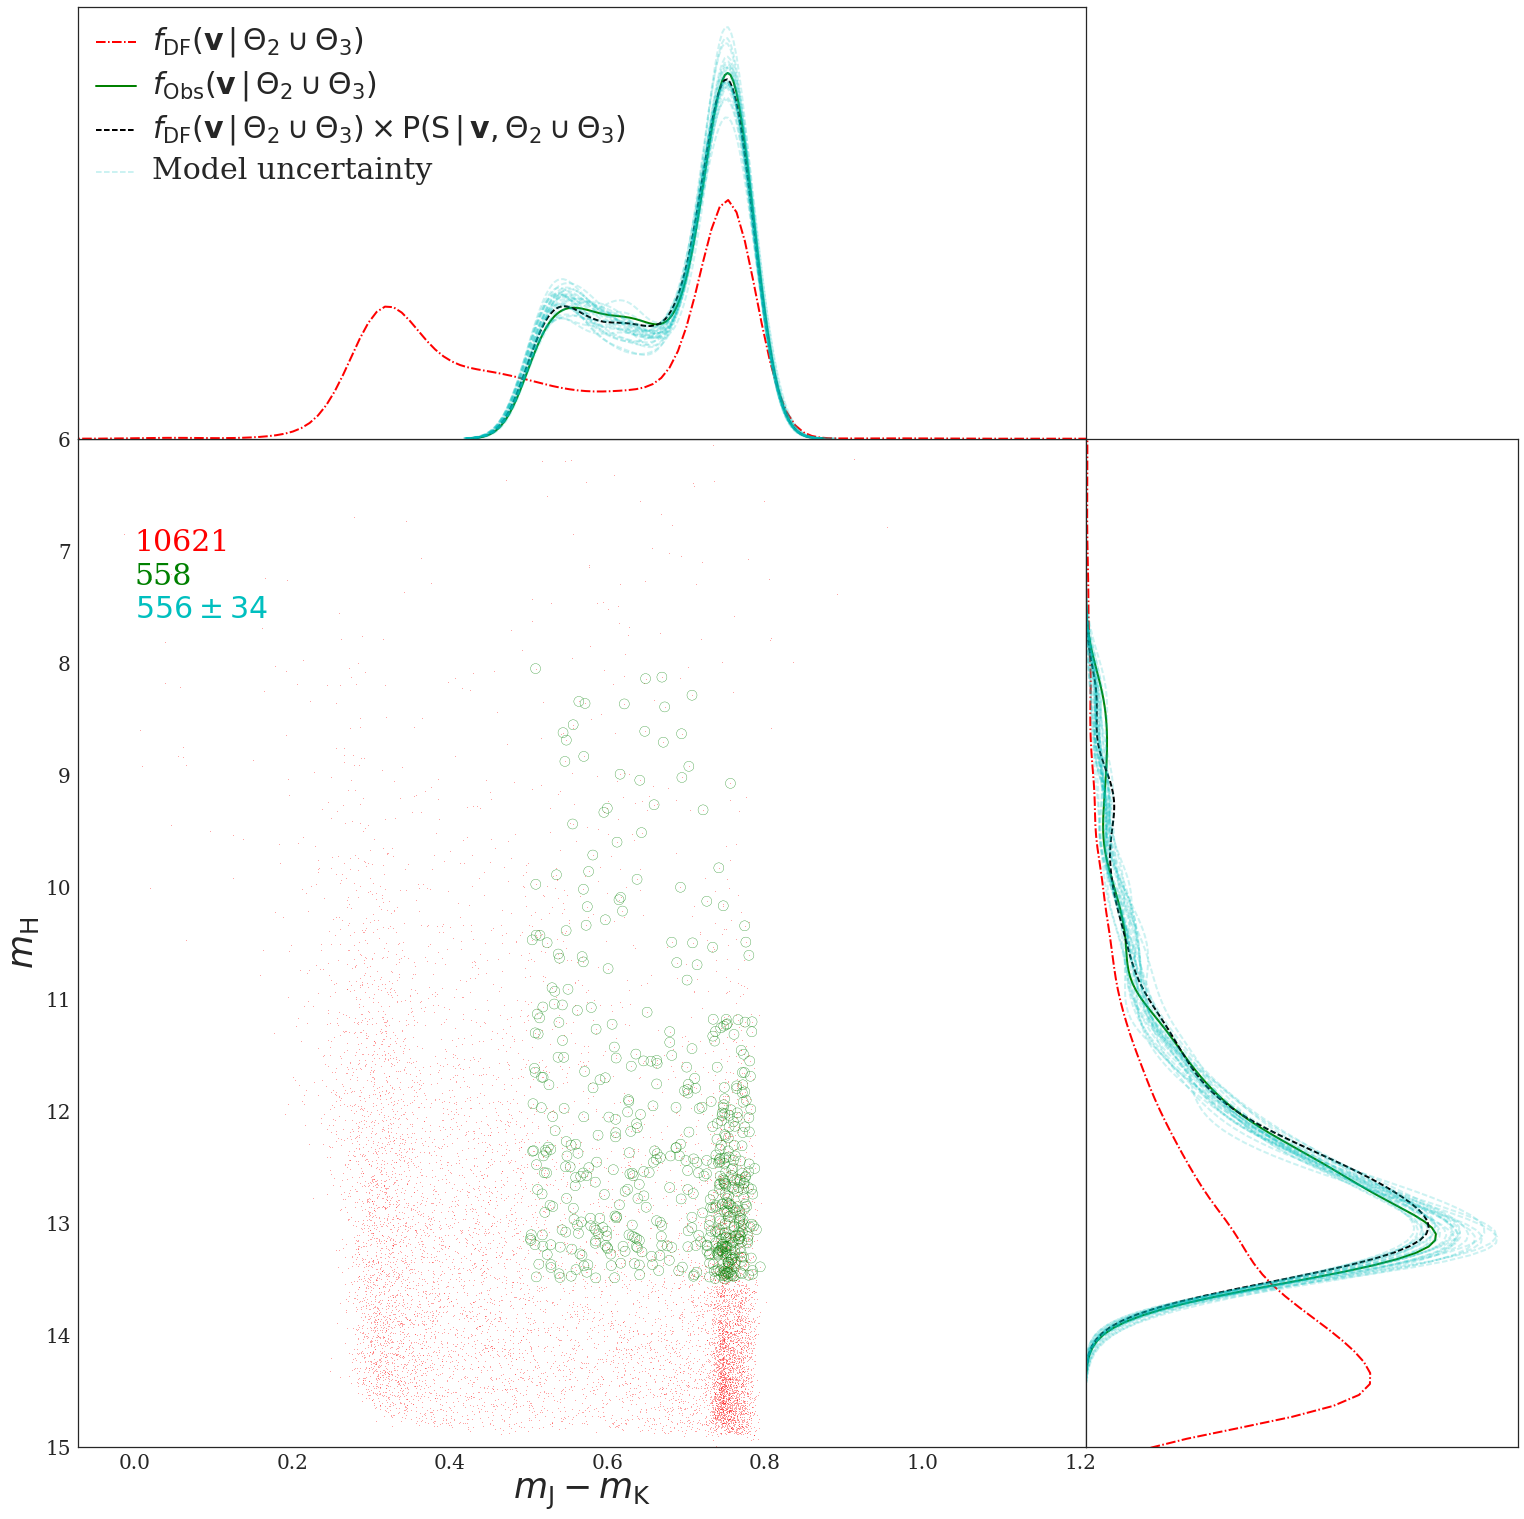

In [31]:
nullfmt = NullFormatter()         # no labels
font = {'family' : 'serif', 'weight' : 'normal',
        'size'   : 80}
legend = {'fontsize': 20}
matplotlib.rc('font', **font)
matplotlib.rc('legend', **legend)
matplotlib.rc('axes', labelsize= 20)

# start with a rectangular Figure
plt.figure(1, figsize=(20, 20))

sml, big = (0.3, 0.7)
ax_c = plt.axes([0, 0, big, big])
ax_t = plt.axes([0, big, big, sml])
ax_s = plt.axes([big, 0., sml, big])

#xlim = (0, 13)
ylim = (15, 6)

# the scatter plot:
ax_c.scatter(full23.Colour, full23.Happ, s=0.1, c='r')
ax_c.scatter(survey23.Colour, survey23.Happ, s=100, marker='o', c='none', edgecolors='g')

#ax_c.set_xlim(xlim)
ax_c.set_ylim(ylim)

label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_2 \cup \Theta_3)$'

plt.sca(ax_t)
sns.kdeplot(full23.Colour, label=label1, alpha=1., c='r', legend=True, linestyle='-.', linewidth=2)
sns.kdeplot(survey23.Colour, label=label2, alpha=1., c='g', legend=True, linestyle='-', linewidth=2)

plt.sca(ax_s)
sns.kdeplot(full23.Happ, alpha=1., c='r', legend=False, vertical=True, linestyle='-.', linewidth=2)
sns.kdeplot(survey23.Happ, alpha=1., c='g', legend=False, vertical=True, linestyle='-', linewidth=2)

    
df_rand = full23[np.random.rand(len(full23)) < full23['union_f']][['Colour', 'Happ']].copy()
kwargs = {'alpha':1., 'color':'k'}
plt.sca(ax_s)
sns.kdeplot(df_rand.Happ, legend=False, vertical=True, linestyle='--', linewidth=2, zorder=2, **kwargs)
plt.sca(ax_t)
sns.kdeplot(df_rand.Colour, linestyle='--', linewidth=2, label=label3, legend=True, zorder=2, **kwargs)
N=Ns
nrand = np.zeros(Ns)
for i in range(N):
    df_rand = full23[np.random.rand(len(full23)) < full23['union_%d' %i]][['Colour', 'Happ']].copy()

    kwargs = {'alpha':0.2, 'color':'c'}
    if i==0: labelargs = {'label':'Model uncertainty', 'legend':True}
    else: labelargs = {'legend':False}

    plt.sca(ax_s)
    sns.kdeplot(df_rand.Happ, legend=False, vertical=True, linestyle='--', linewidth=2, **kwargs)

    plt.sca(ax_t)
    kwargs.update(labelargs)
    sns.kdeplot(df_rand.Colour, linestyle='--', linewidth=2, **kwargs)
    nrand[i] = len(df_rand)
    
    
ax_t.set_xlim(ax_c.get_xlim())
ax_s.set_ylim(ax_c.get_ylim())


plt.sca(ax_c)
textfont = {'fontsize':30}
plt.text(0., 7., str(len(full23)), color='r', fontdict=textfont)
plt.text(0., 7.3, str(len(survey23)), color='g', fontdict=textfont)
plt.text(0., 7.6, r'$%d \pm %d$' % (np.mean(nrand), np.std(nrand)), color='c', fontdict=textfont)


ax_c.tick_params('x', labelsize=20)
ax_c.tick_params('y', labelsize=20)
ax_s.tick_params('both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')
ax_t.tick_params('both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')

ax_c.set_xlabel(r'$m_\mathrm{J} - m_\mathrm{K}$', fontsize=35)
ax_c.set_ylabel(r'$m_\mathrm{H}$', fontsize=35)

plt.setp(ax_t.get_legend().get_texts(), fontsize='30') 

plt.show()

In [32]:
def kde(df, survey, coord, ax, xlabel={}, xlim={}, fs=50, legend=True,
        label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1)$',
        label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_1)$',
        label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_1)$'):
    
    plt.sca(ax)

    sns.kdeplot(df[coord], label=label1, alpha=1., c='r', legend=legend, linestyle='-.', linewidth=2)
    sns.kdeplot(survey[coord], label=label2, alpha=1., c='g', legend=legend,linestyle='-', linewidth=3)

    df_rand = df[np.random.rand(len(df)) < df['union_f']][[coord]].copy()
    kwargs = {'alpha':1., 'color':'k'}
    sns.kdeplot(df_rand[coord], linestyle='--', label=label3, bw='scott', 
                legend=legend, zorder=2, linewidth=4, **kwargs)

    N=Ns
    nrand=np.zeros(Ns)
    for i in range(N):
        df_rand = df[np.random.rand(len(df)) < df['union_%d' %i]][[coord]].copy()

        kwargs = {'alpha':0.2, 'color':'c'}
        if i==0: labelargs = {'label':'Model uncertainty',\
                              'legend':legend}
        else: labelargs = {'legend':False}
        kwargs.update(labelargs)
        sns.kdeplot(df_rand[coord], linestyle='--', linewidth=2, **kwargs)
        nrand[i] = len(df_rand)
        
    if coord=='mh':
        textfont = {'fontsize':30}
        plt.text(-1.3, 2.5, str(len(df)), color='r', fontdict=textfont)
        plt.text(-1.3, 2.25, str(len(survey)), color='g', fontdict=textfont)
        plt.text(-1.3, 2., r'$%d \pm %d$' % (np.mean(nrand), np.std(nrand)), color='c', fontdict=textfont)


    plt.xlim(xlim[coord])
    plt.xlabel(xlabel[coord], fontsize=fs)
    plt.ylabel(ylabel[coord], fontsize=fs)
    if legend: plt.setp(ax.get_legend().get_texts(), fontsize=fs) 

    plt.tick_params('both', labelsize=20)

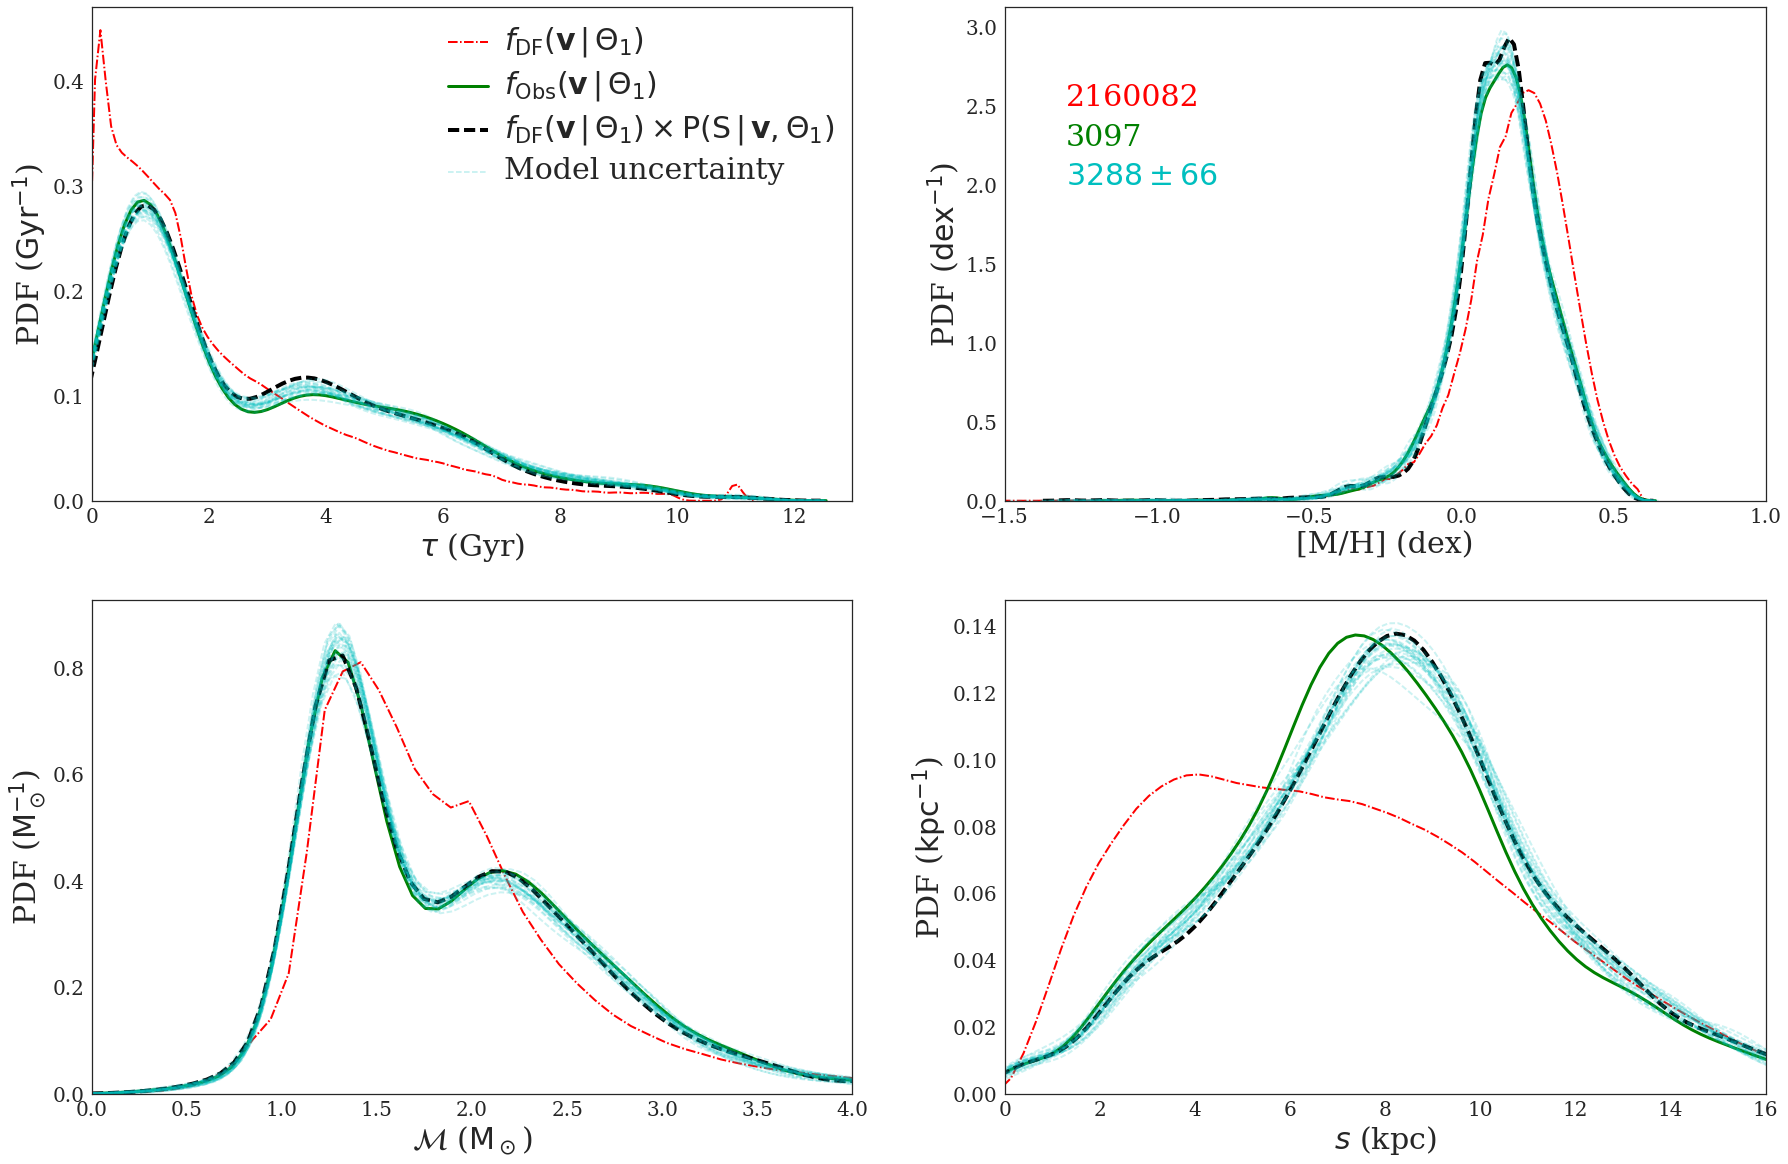

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(30,20))

xlabel = {'mass':r'$\mathcal{M}$ ($\mathrm{M}_\odot$)', 'ageGyr':r'$\tau$ (Gyr)', \
          'mh':r'[M/H] (dex)','s':r'$s$ (kpc)'}
ylabel = {'mass':r'PDF ($\mathrm{M}_\odot^{-1}$)', 'ageGyr':r'PDF ($\mathrm{Gyr}^{-1}$)',\
          'mh':r'PDF ($\mathrm{dex}^{-1}$)', 's':r'PDF ($\mathrm{kpc}^{-1}$)'}
xlim = {'mass':(0,4), 'ageGyr':(0,13), 'mh':(-1.5, 1.0), 's':(0,16)}
coords = ['ageGyr', 'mh', 'mass', 's']

label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_1)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_1)$'

kwargs = {'xlabel':xlabel, 'xlim':xlim, 'fs':30, 'label1':label1, 'label2':label2, 'label3':label3}

kde(full1, survey1, coords[0], ax[0,0], **kwargs)
kde(full1, survey1, coords[1], ax[0,1], legend=False, **kwargs)
kde(full1, survey1, coords[2], ax[1,0], legend=False, **kwargs)
kde(full1, survey1, coords[3], ax[1,1], legend=False, **kwargs)

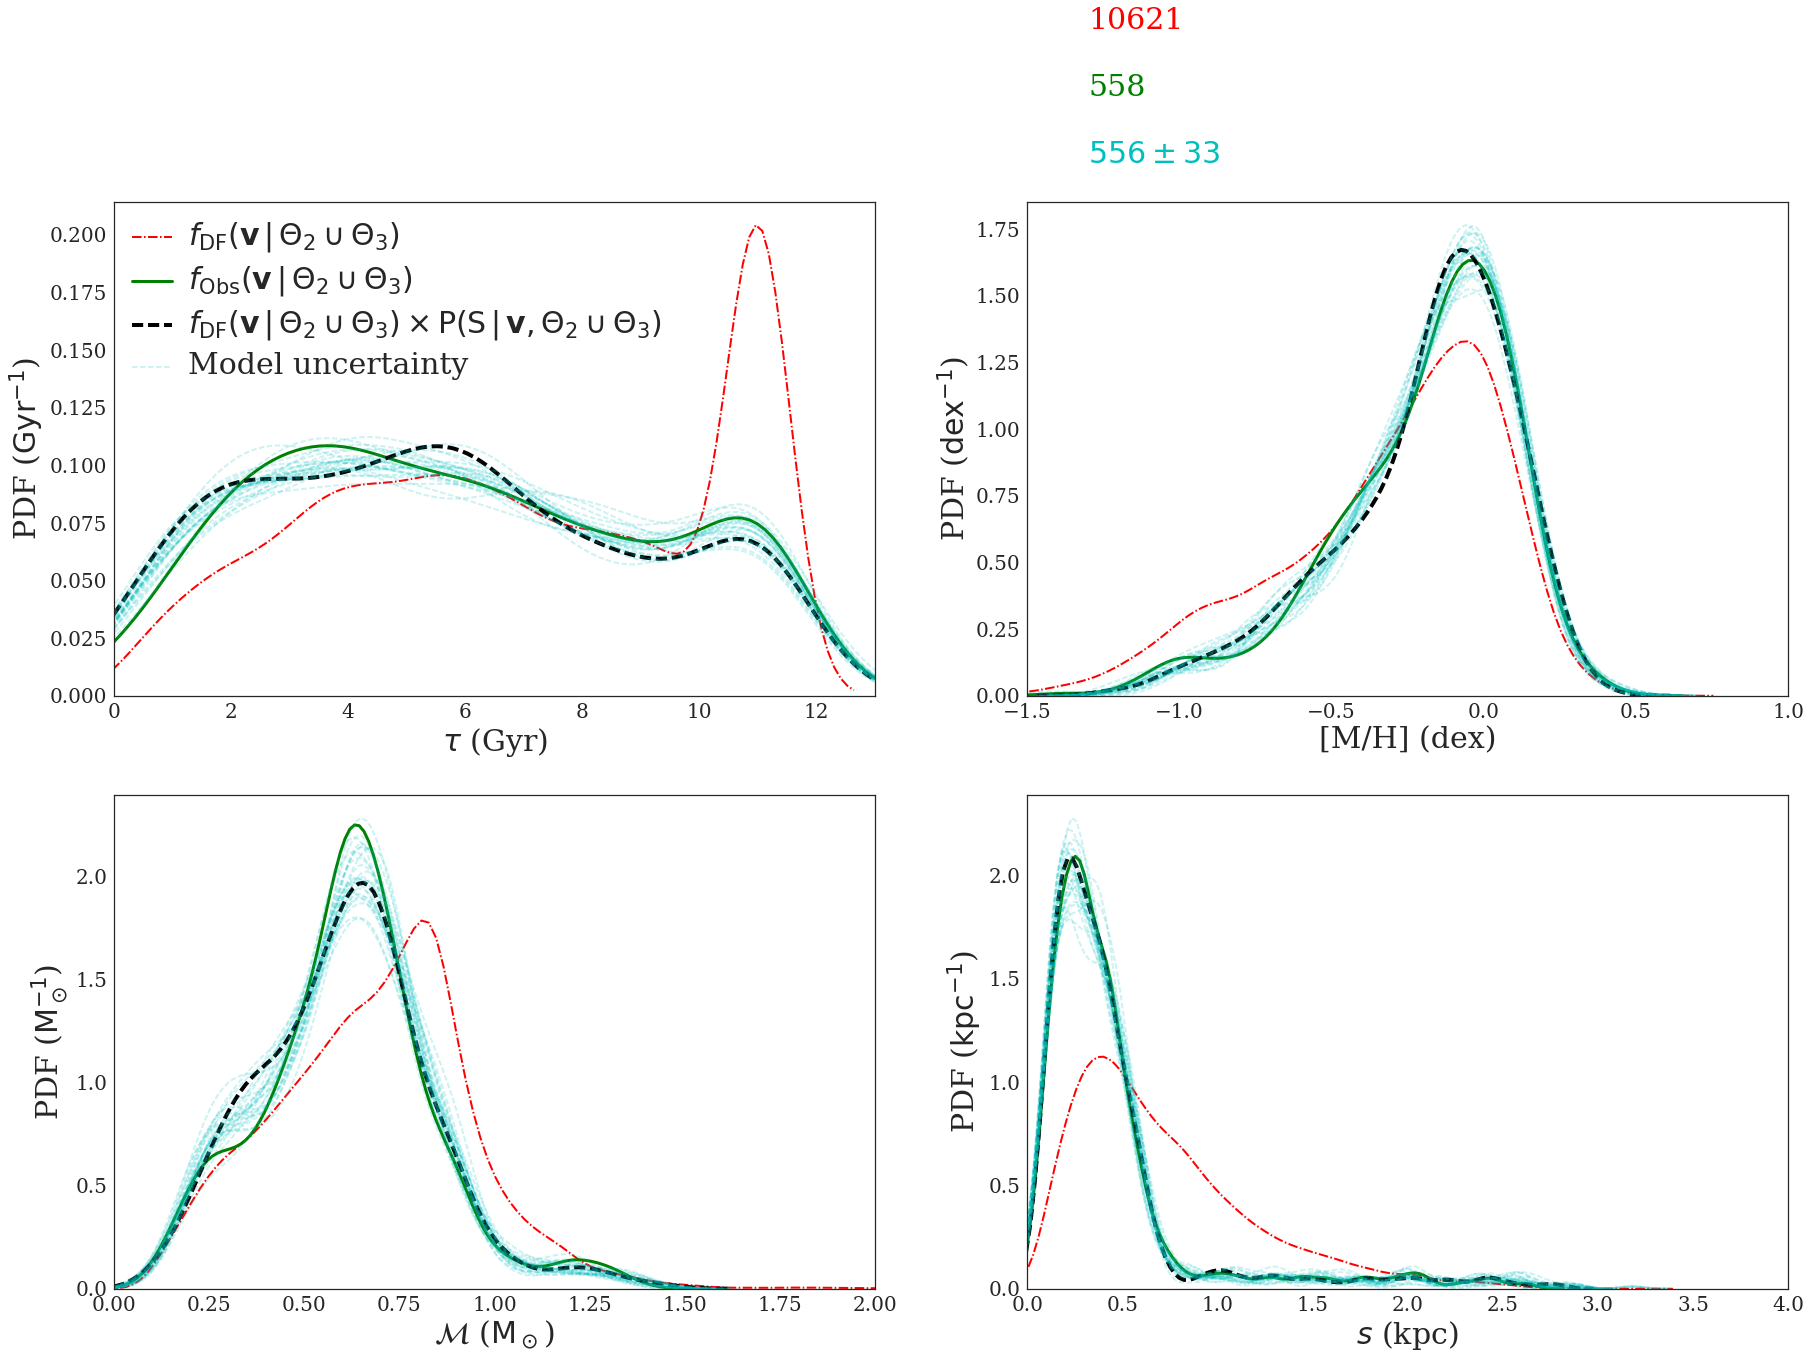

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(30,20))

xlabel = {'mass':r'$\mathcal{M}$ ($\mathrm{M}_\odot$)', 'ageGyr':r'$\tau$ (Gyr)', \
          'mh':r'[M/H] (dex)','s':r'$s$ (kpc)'}
ylabel = {'mass':r'PDF ($\mathrm{M}_\odot^{-1}$)', 'ageGyr':r'PDF ($\mathrm{Gyr}^{-1}$)',\
          'mh':r'PDF ($\mathrm{dex}^{-1}$)', 's':r'PDF ($\mathrm{kpc}^{-1}$)'}
xlim = {'mass':(0,2.), 'ageGyr':(0,13), 'mh':(-1.5, 1.0), 's':(0,4)}
coords = ['ageGyr', 'mh', 'mass', 's']

label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_2 \cup \Theta_3)$'

kwargs = {'xlabel':xlabel, 'xlim':xlim, 'fs':30, 'label1':label1, 'label2':label2, 'label3':label3}

kde(full23, survey23, coords[0], ax[0,0], **kwargs)
kde(full23, survey23, coords[1], ax[0,1], legend=False, **kwargs)
kde(full23, survey23, coords[2], ax[1,0], legend=False, **kwargs)
kde(full23, survey23, coords[3], ax[1,1], legend=False, **kwargs)

In [ ]:
full1['Habs'] = full1.Happ - 5*np.log10(full1.s*100)
survey1['Habs'] = survey1.Happ - 5*np.log10(survey1.s*100)

full23['Habs'] = full23.Happ - 5*np.log10(full23.s*100)
survey23['Habs'] = survey23.Happ - 5*np.log10(survey23.s*100)

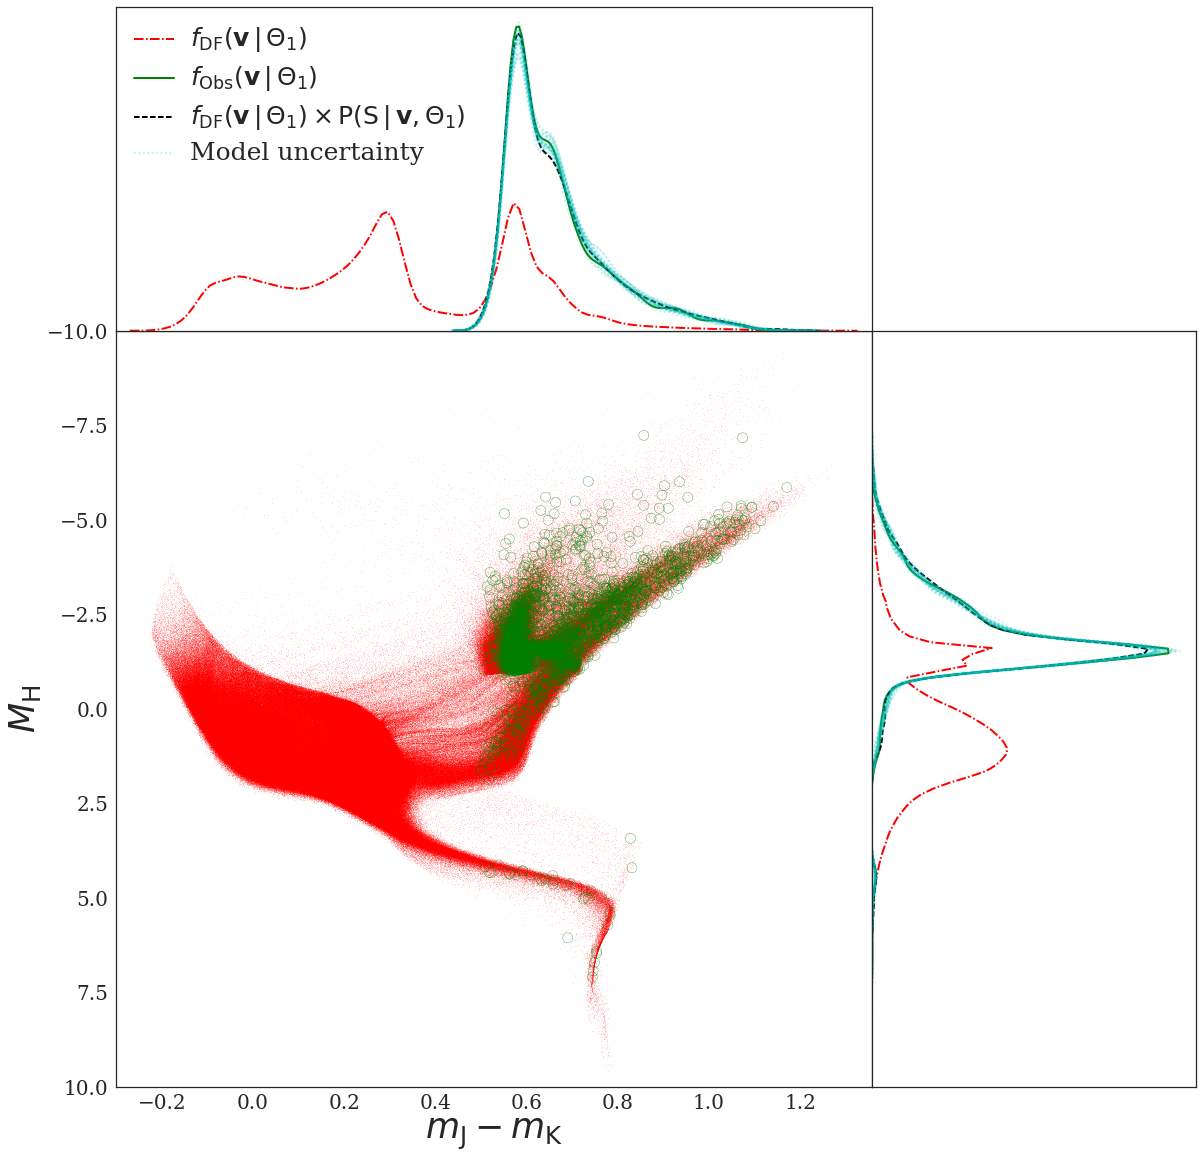

In [41]:
nullfmt = NullFormatter()         # no labels
font = {'family' : 'serif', 'weight' : 'normal',
        'size'   : 80}
legend = {'fontsize': 20}
matplotlib.rc('font', **font)
matplotlib.rc('legend', **legend)
matplotlib.rc('axes', labelsize= 20)

# start with a rectangular Figure
plt.figure(1, figsize=(15, 15))

sml, big = (0.3, 0.7)
ax_c = plt.axes([0, 0, big, big])
ax_t = plt.axes([0, big, big, sml])
ax_s = plt.axes([big, 0., sml, big])

#xlim = (0, 13)
ylim = (10,-10)

# the scatter plot:
ax_c.scatter(full1.Colour, full1.Habs, s=0.01, c='r')
ax_c.scatter(survey1.Colour, survey1.Habs, s=100, marker='o', c='none', edgecolors='g')

#ax_c.set_xlim(xlim)
ax_c.set_ylim(ylim)

label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_1)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_1)$'

plt.sca(ax_t)
sns.kdeplot(full1.Colour, label=label1, alpha=1., c='r', legend=True, linestyle='-.', linewidth=2)
sns.kdeplot(survey1.Colour, label=label2, alpha=1., c='g', legend=True, linestyle='-', linewidth=2)

plt.sca(ax_s)
sns.kdeplot(full1.Habs, alpha=1., c='r', legend=False, vertical=True, linestyle='-.', linewidth=2)
sns.kdeplot(survey1.Habs, alpha=1., c='g', legend=False, vertical=True, linestyle='-', linewidth=2)

df_rand = full1[np.random.rand(len(full1)) < full1['union_f']][['Colour', 'Habs']].copy()
kwargs = {'alpha':1., 'color':'k'}
plt.sca(ax_s)
sns.kdeplot(df_rand.Habs, legend=False, vertical=True, linestyle='--', linewidth=2, zorder=2, **kwargs)
plt.sca(ax_t)
sns.kdeplot(df_rand.Colour, linestyle='--', linewidth=2, label=label3, legend=True, zorder=2, **kwargs)
N=Ns
for i in range(N):
    df_rand = full1[np.random.rand(len(full1)) < full1['union_%d' %i]][['Colour', 'Habs']].copy()

    kwargs = {'alpha':0.2, 'color':'c'}
    if i==0: labelargs = {'label':'Model uncertainty', 'legend':True}
    else: labelargs = {'legend':False}

    plt.sca(ax_s)
    sns.kdeplot(df_rand.Habs, legend=False, vertical=True, linestyle=':', linewidth=2, **kwargs)

    plt.sca(ax_t)
    kwargs.update(labelargs)
    sns.kdeplot(df_rand.Colour, linestyle=':', linewidth=2, **kwargs)
    
    
ax_t.set_xlim(ax_c.get_xlim())
ax_s.set_ylim(ax_c.get_ylim())

ax_c.tick_params('x', labelsize=20)
ax_c.tick_params('y', labelsize=20)
ax_s.tick_params('both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')
ax_t.tick_params('both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')

ax_c.set_xlabel(r'$m_\mathrm{J} - m_\mathrm{K}$', fontsize=35)
ax_c.set_ylabel(r'$M_\mathrm{H}$', fontsize=35)

plt.setp(ax_t.get_legend().get_texts(), fontsize='25') 

plt.show()

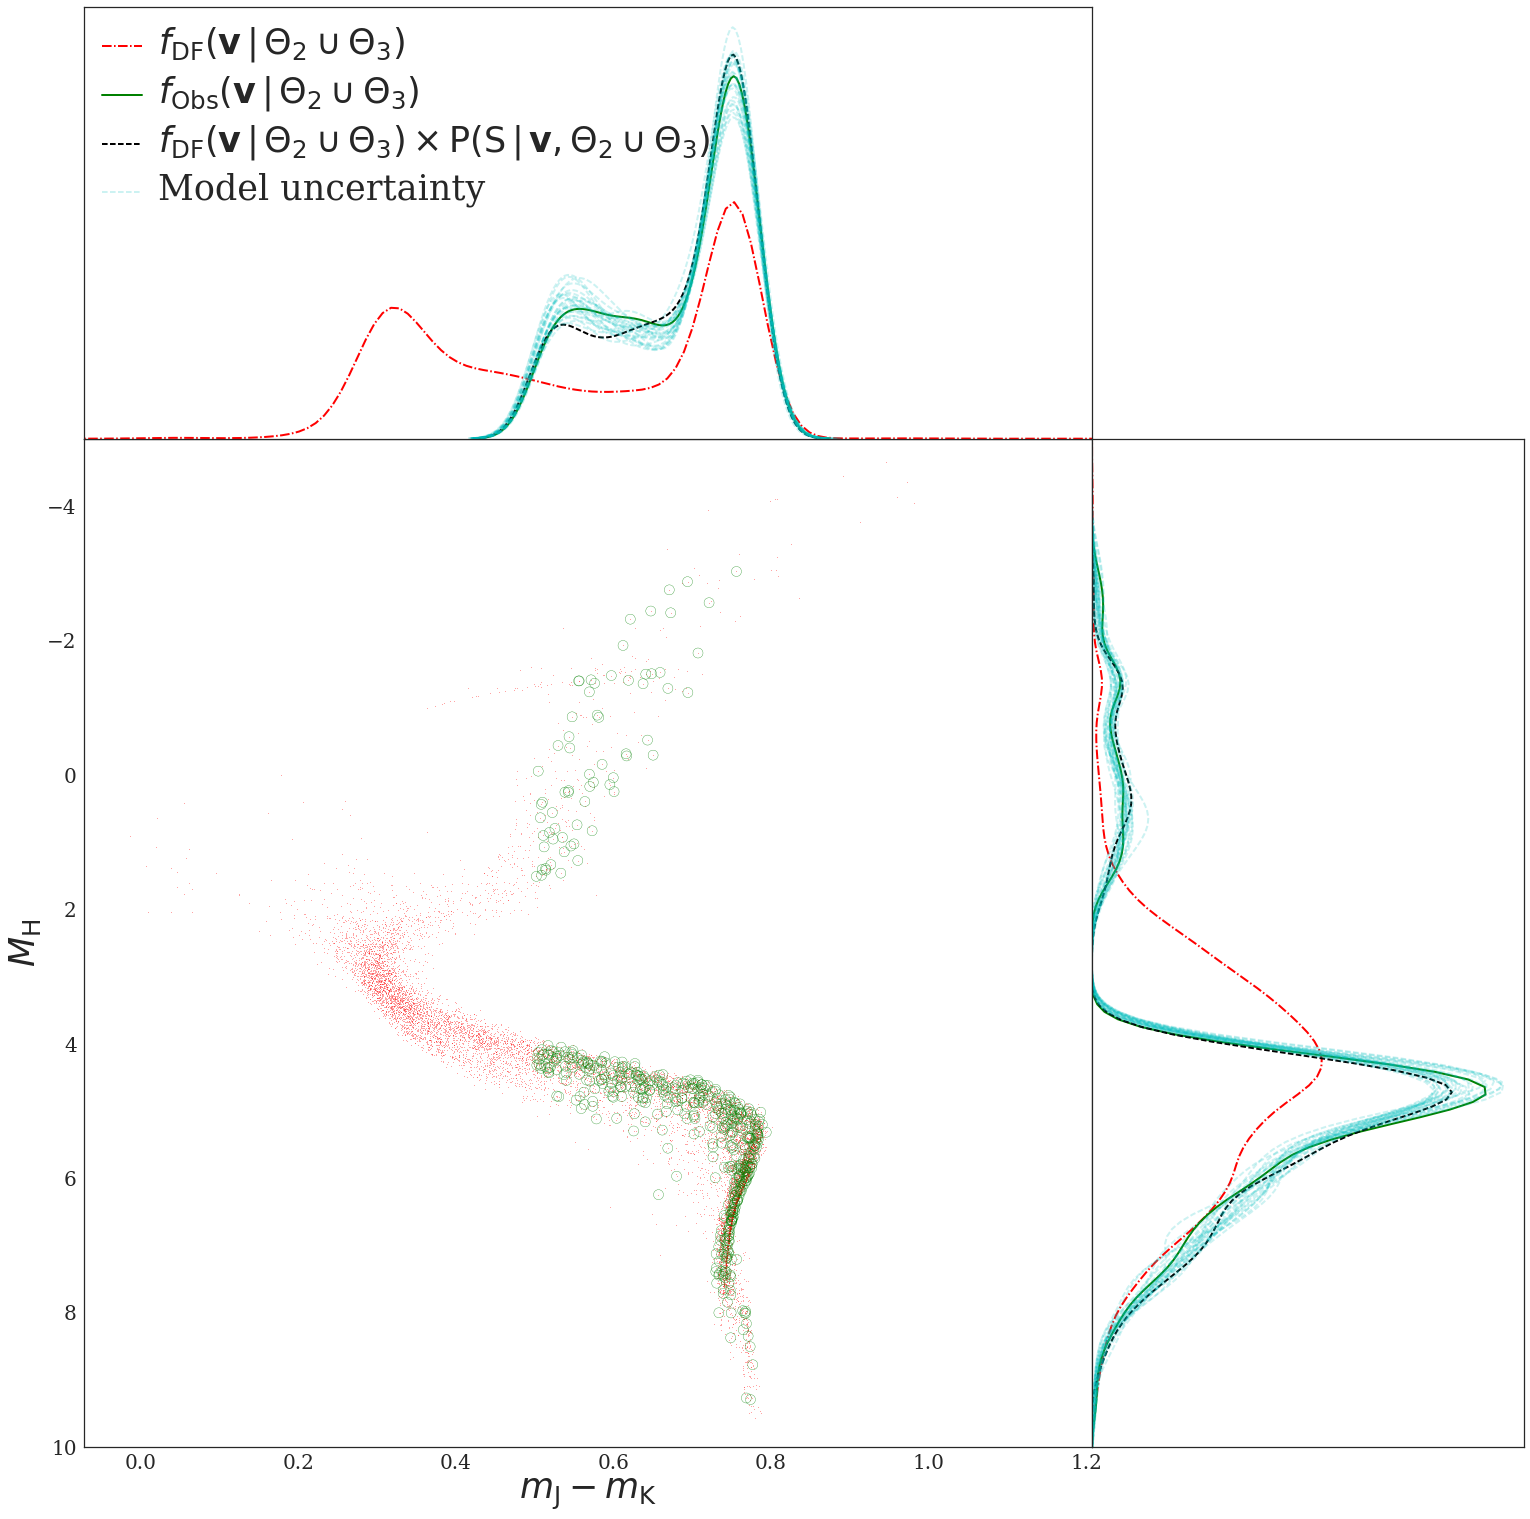

In [42]:
nullfmt = NullFormatter()         # no labels
font = {'family' : 'serif', 'weight' : 'normal',
        'size'   : 80}
legend = {'fontsize': 20}
matplotlib.rc('font', **font)
matplotlib.rc('legend', **legend)
matplotlib.rc('axes', labelsize= 20)

# start with a rectangular Figure
plt.figure(1, figsize=(20, 20))

sml, big = (0.3, 0.7)
ax_c = plt.axes([0, 0, big, big])
ax_t = plt.axes([0, big, big, sml])
ax_s = plt.axes([big, 0., sml, big])

#xlim = (0, 13)
ylim = (10,-5)

# the scatter plot:
ax_c.scatter(full23.Colour, full23.Habs, s=0.1, c='r')
ax_c.scatter(survey23.Colour, survey23.Habs, s=100, marker='o', c='none', edgecolors='g')

#ax_c.set_xlim(xlim)
ax_c.set_ylim(ylim)

label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_2 \cup \Theta_3)$'

plt.sca(ax_t)
sns.kdeplot(full23.Colour, label=label1, alpha=1., c='r', legend=True, linestyle='-.', linewidth=2)
sns.kdeplot(survey23.Colour, label=label2, alpha=1., c='g', legend=True, linestyle='-', linewidth=2)

plt.sca(ax_s)
sns.kdeplot(full23.Habs, alpha=1., c='r', legend=False, vertical=True, linestyle='-.', linewidth=2)
sns.kdeplot(survey23.Habs, alpha=1., c='g', legend=False, vertical=True, linestyle='-', linewidth=2)

    
df_rand = full23[np.random.rand(len(full23)) < full23['union_f']][['Colour', 'Habs']].copy()
kwargs = {'alpha':1., 'color':'k'}
plt.sca(ax_s)
sns.kdeplot(df_rand.Habs, legend=False, vertical=True, linestyle='--', linewidth=2, zorder=2, **kwargs)
plt.sca(ax_t)
sns.kdeplot(df_rand.Colour, linestyle='--', linewidth=2, label=label3, legend=True, zorder=2, **kwargs)
N=Ns
for i in range(N):
    df_rand = full23[np.random.rand(len(full23)) < full23['union_%d' %i]][['Colour', 'Habs']].copy()

    kwargs = {'alpha':0.2, 'color':'c'}
    if i==0: labelargs = {'label':'Model uncertainty', 'legend':True}
    else: labelargs = {'legend':False}

    plt.sca(ax_s)
    sns.kdeplot(df_rand.Habs, legend=False, vertical=True, linestyle='--', linewidth=2, **kwargs)

    plt.sca(ax_t)
    kwargs.update(labelargs)
    sns.kdeplot(df_rand.Colour, linestyle='--', linewidth=2, **kwargs)
    
    
ax_t.set_xlim(ax_c.get_xlim())
ax_s.set_ylim(ax_c.get_ylim())

ax_c.tick_params('x', labelsize=20)
ax_c.tick_params('y', labelsize=20)
ax_s.tick_params('both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')
ax_t.tick_params('both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')

ax_c.set_xlabel(r'$m_\mathrm{J} - m_\mathrm{K}$', fontsize=35)
ax_c.set_ylabel(r'$M_\mathrm{H}$', fontsize=35)

plt.setp(ax_t.get_legend().get_texts(), fontsize='35') 

plt.show()

In [28]:
from seestar import StatisticalModels

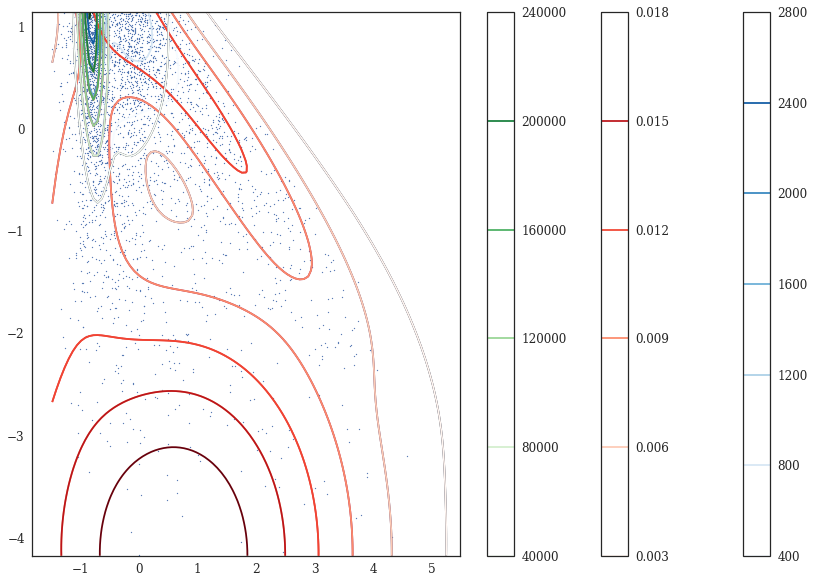

In [44]:
field=1.0
instsf = SF.obsSF[field].SF_model
instdf = SF.obsSF[field].DF_model
plt.figure(figsize=(15,10))

plt.scatter(instsf.y_s, instsf.x_s, s=1)
#plt.scatter(instsf.x_s, instsf.y_s, s=0.1)

#instsf.params_f = instsf.unscaleParams(instsf.params_f_scaled)

x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)

#plt.scatter(instsf.params_f_scaled[:,0], instsf.params_f_scaled[:,1], c='g')
#plt.scatter(instsf.params_i[:,0], instsf.params_i[:,1], c='r')

all_pars = StatisticalModels.gmm_product_p(instsf.params_f_scaled, instsf.params_df)
all_pars = all_pars.reshape(-1, all_pars.shape[-1])
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz, cmap='Blues')
plt.colorbar()

all_pars = instsf.params_f_scaled
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Reds')
plt.colorbar()

all_pars = instsf.params_df
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Greens')
plt.colorbar()
